# 教程5: RJMCMC with Eryn


在第五篇教程中，我们将看看当基础模型发生变化时如何运行Eryn。这意味着我们将使用可逆跳跃MCMC，也称为跨维MCMC。在本教程中，将只有两个任务，因为RJMCMC很复杂，并且将RJMCMC运行放在一起需要时间和精力。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful

## 任务1:有多少高斯脉冲?


我们要看的第一个RJ问题是确定有噪声的数据集中存在多少2D高斯脉冲。你可以在更高级的Eryn教程中找到这个例子。为了在分配时间内保持简单，我们将使用基于先验分布的建议(这是默认的)。如果你在`EnsembleSampler`的设置中设置`rj_moves=True`，它将自动从先验信息中生成RJ建议。然而，在使用多个分支(模型类型)时必须小心，因为此建议默认情况下总是建议将采样器中的每个模型更改1个模型计数，要么添加，要么删除。

有用的文档:
* [EnsembleSampler](https://mikekatz04.github.io/Eryn/html/user/ensemble.html#eryn.ensemble.EnsembleSampler)
* [State](https://mikekatz04.github.io/Eryn/html/user/state.html#eryn.state.State)
* [uniform_dist](https://mikekatz04.github.io/Eryn/html/user/prior.html#eryn.prior.uniform_dist)
* [ProbDistContainer](https://mikekatz04.github.io/Eryn/html/user/prior.html#eryn.prior.ProbDistContainer)
* [GaussianMove](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.GaussianMove)
* [DistributionGenerateRJ](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.DistributionGenerateRJ)

In [2]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.moves import GaussianMove
from eryn.backends import HDFBackend
from chainconsumer import ChainConsumer, Chain


我们会为你做初始设置。在这里，我们将设置2D网格的x和y维度。

In [3]:
num     = 100 # the number of step for each dimension
lowlim  = -10 # Low limit on each axis
highlim = 10  # high limit on each axis
npulses = 10  # The # of injected pulses

dx = (highlim - lowlim) / num # Get the discritization

x, y = np.mgrid[lowlim:highlim:dx, lowlim:highlim:dx]  # Generate the grid


现在，我们将为每组脉冲画出初始参数。每个脉冲都有一个振幅、x和y值。

In [4]:
Amp    = np.random.uniform(.5, 2.0, size=(npulses)) # Draw an amplitude
spread = .2  # Keep their spread as fixed for simplicity.
sigma  = spread * np.diag(np.ones(2))

edges = 2 # Utility parameter, in order to avoid having signals at the border of our data set

# Draw the coordinates parameters
# generates random x and y coordinates
inj_coordinates = np.random.uniform(lowlim+edges, highlim-edges, size=(npulses, 2))

# Gather all parameters here
gauss_inj_params = np.concatenate([Amp[:, None], inj_coordinates], axis=1)

print(' * Parameters injected: \n\n', np.matrix(gauss_inj_params))

 * Parameters injected: 

 [[ 0.5392097  -7.02012643 -4.29637362]
 [ 0.68873674  4.93040169 -4.26526376]
 [ 1.89901339 -4.23884024  5.91611643]
 [ 1.28977125 -2.14487825  7.22037659]
 [ 1.54025583  3.78565562  5.43886843]
 [ 1.95547839 -0.42049586  1.8888709 ]
 [ 1.73939714 -3.02318019 -7.48916717]
 [ 0.65731986  1.96418607  4.33997957]
 [ 1.95106844 -6.02542211 -0.57486067]
 [ 1.55534297 -6.10430806 -6.34189646]]



为了避免任何问题，我们还填充了高斯函数和似然函数。接下来的几个单元格给出了注射数据的大致情况。

In [5]:
# First we compute some constant terms of the Gaussian models (reminder: we have assumed a fixed spread for each pulse)
sigma_det = np.linalg.det(sigma)
sigma_inv = np.linalg.inv(sigma)
norm      = np.sqrt((2*np.pi)**2 * sigma_det)

def gaussian(X, Y, a, b, c):
    x = X[:,0]
    y = Y[0,:]
    # breakpoint()
    A = np.exp(-((x[None, :] - b[:, None]) ** 2) / (2 * sigma[0,0]))
    B = np.exp(-((y[None, :] - c[:, None]) ** 2) / (2 * sigma[1,1]))
    # breakpoint()
    C =  A[:, None, :] * B[:, :, None] # (np.expand_dims(A,axis=0) * np.expand_dims(np.transpose(B),axis=2))

    return a[:, None, None] * C / norm

def log_prob_fn(x1, X, Y, data, sig):

    a = x1[:, 0]
    b = x1[:, 1]
    c = x1[:, 2]
    n = num * num

    template  = np.sum(gaussian(X, Y, a, b, c), axis=0)

    llh = - 0.5 * ( np.sum(((template - data)) ** 2) )
    llh *= 1/sig**2
    llh += - n*np.log(sig) - .5 * n * np.log(2.*np.pi)
    return llh

In [6]:
noise = spread * np.random.randn( num, num ) # Draw the random points for the noise

# Generate the data-set
injection = np.zeros( (num, num) )
injection = np.sum(gaussian(x, y, gauss_inj_params[:, 0], gauss_inj_params[:, 1], gauss_inj_params[:, 2]), axis=0)
data = injection + noise


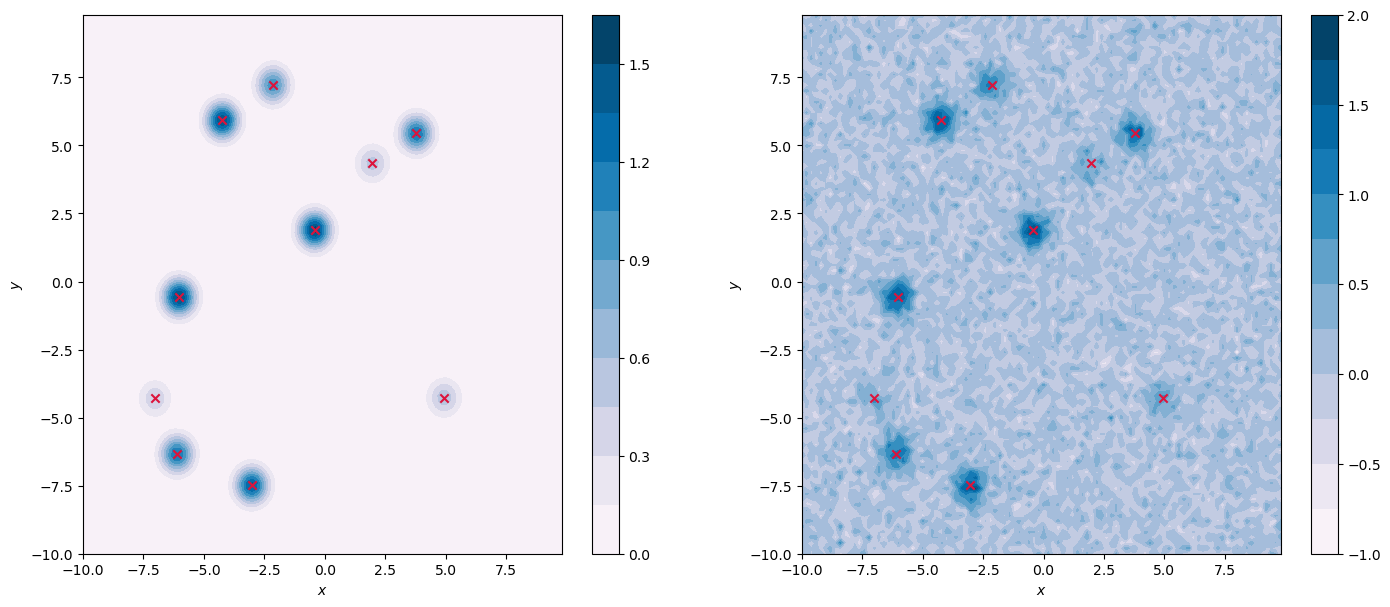

In [7]:
from matplotlib import cm

plt.figure(figsize=(17,7))
plt.subplot(121)
cf = plt.contourf(y, x, injection, 10, cmap=cm.PuBu)
plt.scatter(gauss_inj_params[:,1], gauss_inj_params[:,2], marker='x', color='#DC143C')
plt.colorbar(cf)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.subplot(122)
cf = plt.contourf(y, x, data, 10, cmap=cm.PuBu)
plt.scatter(gauss_inj_params[:,1], gauss_inj_params[:,2], marker='x', color='#DC143C')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(cf)
plt.show()



现在我们已经完成了大部分初始设置。现在我们需要构建采样运行程序。让我们从选择设置和构建基本需求开始:`ndims`， `nleaves_max`， `nleaves_min`， `branch_names`， `ntemps`， `nwalkers`。

In [8]:
ntemps = 10
nwalkers = 30

ndims        = {"pulse": 3}           # The dimensions of the two models we sample for here (# of parameter for each pulse, and # of parameters for the noise)
nleaves_max  = {"pulse": 2*npulses}   # Maximum number of components for each model type (noise is 1, because we don't want to use RJ MCMC on it).
nleaves_min = {"pulse": 0}
branch_names = ["pulse"]

现在我们将设置前面的函数。确保你使用Eryn的`ProbDistContainer`对象初始化你的prior。
* 对于振幅，从0.5到2.0的均匀先验。
* 对于x和y，在可接受的范围内统一先验。

In [9]:
priors = {
    "pulse": ProbDistContainer({
        0: uniform_dist(0.5, 2.),
        1: uniform_dist(lowlim, highlim),
        2: uniform_dist(lowlim, highlim),
    })
}

当使用RJMCMC时，我们必须在`EnsembleSampler`中为`moves`输入一个值。这是因为默认建议框(拉伸建议框)不能在不同的维度上工作。我们将保持简单，使用以当前点为中心的高斯建议。我们推荐使用对角协方差矩阵，每个参数具有相同的协方差。有很多方法可以做到这一点。

有用的文档:
* [GaussianMove](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.GaussianMove)

In [10]:
# imports 
from eryn.moves import GaussianMove

In [11]:
factor = 0.01
cov    = {"pulse": np.diag(np.ones(3)) * factor}
moves = GaussianMove(cov)


现在我们将实例化`EnsembleSampler`。设置`tempering_kwargs=dict(ntemps=ntemps)`进行调质。

In [12]:
ensemble = EnsembleSampler(
    nwalkers,
    ndims,  # assumes ndim_max
    log_prob_fn,
    priors,
    args=[x, y, data, sigma_det],
    tempering_kwargs=dict(ntemps=ntemps),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    moves=moves,
    rj_moves=True,
)

 # Number of samples per walker


准备好采样器后，我们只需要生成我们的起点。这方面也有很多选择。在RJMCMC中，由于模型的不确定性，使得问题更加复杂。对于这个简化的例子，我们将从从先验图中绘制**每个walker一个高斯**开始。随着时间的推移，还会增加更多。你的目标是生成一个形状为`(ntemps, nwalkers, nleaves_max, ndim)`的`coords`字典。你可以对`coords`数组中的每个源进行采样，因为我们将使用`inds`字典指定每个walker **只有一个**叶子节点。`inds`应该是一个形状为`(ntemps, nwalkers, nleaves_max)`的布尔数组。然后索引它并为每个漫步者设置一个值为True。将这些字典填充到一个`State`对象中。

In [13]:
# nleaves max here is just for correct shape. Will turn off all but 1 per walker to start
coords = {
    name: priors[name].rvs(size=(ntemps, nwalkers, nleaves_max[name]))
    for name in branch_names
} 

inds_tmp = np.zeros(coords['pulse'].shape[:-1], dtype=bool)
inds_tmp[:, :, 0] = True

inds = {'pulse': inds_tmp}
state = State(coords, inds=inds)

现在运行采样器。我们建议好好锻炼一下。

In [14]:
nsteps = 5000
output = ensemble.run_mcmc(state, nsteps, burn=1000, progress=True, thin_by=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [11:26<00:00,  7.29it/s]



现在使用`ensemble.backend`读取冷链中每个walker的叶子数。你只需要`inds`数组。绘制冷链中脉冲数量的直方图。这是模型计数的后验分布。

有用的文档:
* [Backend](https://mikekatz04.github.io/Eryn/html/user/backend.html#eryn.backends.Backend)

<>:23: SyntaxWarning: invalid escape sequence '\#'
<>:23: SyntaxWarning: invalid escape sequence '\#'
/tmp/ipykernel_2010/555174071.py:23: SyntaxWarning: invalid escape sequence '\#'
  plt.xlabel("$\#$ of peaks in the data")


Text(0.5, 0, '$\\#$ of peaks in the data')

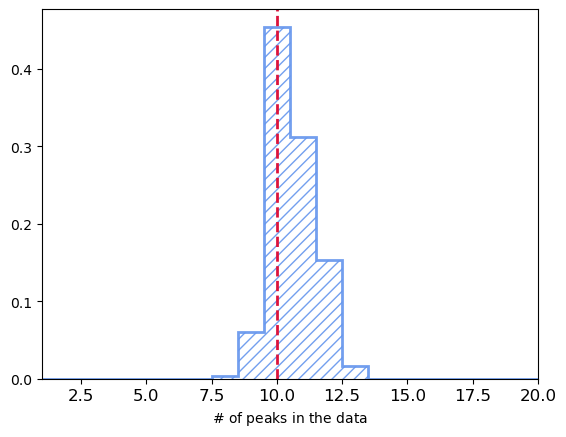

In [15]:
# get leaves from all steps after burn-in and remove higher temperature chains 
# this is the 0 index below
nleaves = ensemble.backend.get_nleaves()["pulse"][:, 0].flatten() 

bins = (np.arange(1, nleaves_max['pulse'] + 2) - 0.5)  # Get maximum allowed number of leaves for the given branch

plt.hist(
    nleaves,
    bins=bins,
    color='#6495ed',
    alpha=0.9,
    lw=2,
    histtype='step',
    density=True,
    hatch='///'
)

# injection line 

plt.axvline(x=int(npulses), linestyle='--', lw=2, color='#DC143C')
plt.xticks(fontsize=12)
plt.xlim(1, 20)
plt.xlabel("$\#$ of peaks in the data")

### 问题:

这是你所期望的吗?RJMCMC告诉我们“正确”答案是什么吗?你认为噪声是如何影响这个后验图的?如果我们增加噪声，我们期望什么样的变化，为什么?



现在我们来看看恢复脉冲的参数，看看我们对注入脉冲的定位有多好。为了做到这一点，我们将从所有发现的叶子数量中扁平化所有样本，即我们将取冷链中的每个单一来源，并将所有这些重叠绘制出来。**提示**:在这里使用`inds`数组。

我们建议使用`pandas`和`chainconsumer`来实现这一点，但你也可以使用你喜欢的任何方式。

In [16]:
import pandas as pd

Parameter $A$ in chain Test is not constrained
Parameter $x$ in chain Test is not constrained
Parameter $y$ in chain Test is not constrained


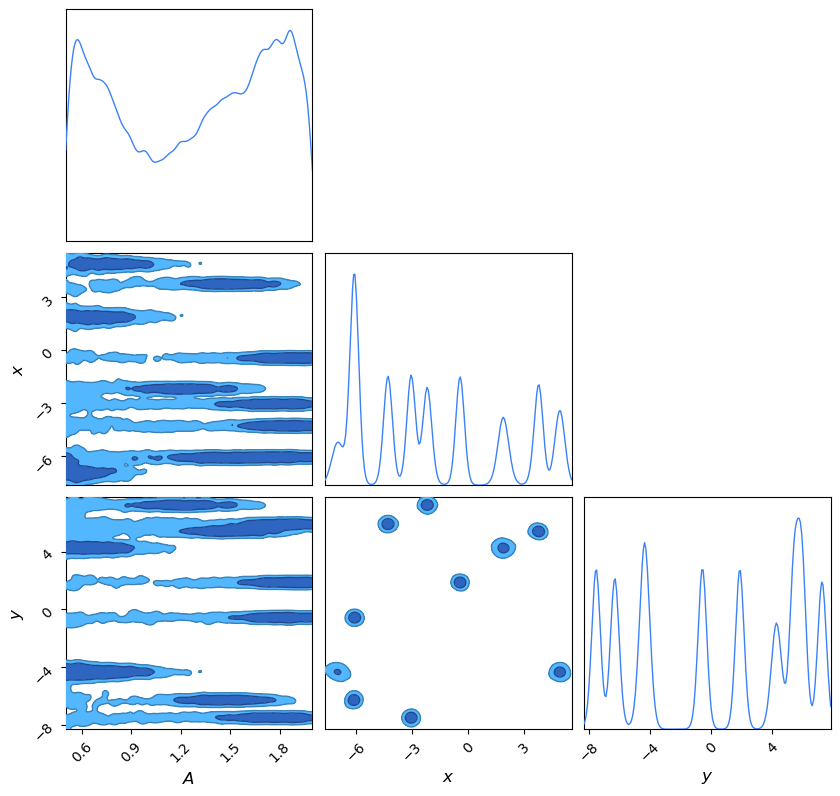

In [17]:
pulse_parameters = ["$A$", r"$x$", r"$y$"]

samples_pulses = ensemble.backend.get_chain()['pulse'][ensemble.backend.get_inds()["pulse"]]

df = pd.DataFrame({key: val for key, val in zip(pulse_parameters, samples_pulses.T)})
c = ChainConsumer()
check = int(3)
c.add_chain(Chain(samples=df, name="Test", smooth=check))
fig = c.plotter.plot()

### 问题:
我们做得怎么样?它成功了吗?会有改进吗?

## 任务2:使用RJMCMC进行模型选择


在这个任务中，您将使用RJMCMC来进行直接的模型比较。这将与教程3中比较高斯脉冲和柯西脉冲的模型比较相同。在教程3中，我们使用固定维MCMC和热力学积分来估计每个模型的证据。然后我们比较它们以得到贝叶斯因子。使用RJMCMC将产生模型选择指数的后验分布，而不是每个模型的直接证据。突出一种模型的步行者的比例代表了优势比。当一种模型比另一种模型更受青睐时，这并不严格成立。然而，当模型的好感度很接近时，这种直接计算是可以的。

为简单起见，我们将信号的扩展值设为1。因此，我们只是拟合和比较脉冲的振幅和平均值。

同样，我们将从提供高斯脉冲、柯西脉冲和似然函数的函数开始。

In [18]:
from scipy.stats import cauchy
def gaussian_pulse(x, a, b):
    f_x = a * np.exp(-((x - b) ** 2) / (2 * 1.0 ** 2))
    return f_x

def cauchy_pulse(x, a, b):
    f_x = a * cauchy.pdf(x - b)
    return f_x

def log_like_fn(params, t, data, sigma, which_template):

    pulse_gen = gaussian_pulse if which_template == "gauss" else cauchy_pulse
    template = pulse_gen(t, *params)

    ll = -0.5 * np.sum(((template - data) / sigma) ** 2, axis=-1)
    return ll

def log_like_wrap(params, *args):
    # must be careful about how these models are read into the Likelihood function
    # In this case, we will have one model with a single set of parameters 
    # and one model that is None
    
    assert len(params) == 2
    if params[0] is not None:
        assert params[1] is None
        # gauss will be first set of params
        args += ("gauss",)
        ll = log_like_fn(params[0][0], *args)

    else:
        assert params[0] is None
        # gauss will be first set of params
        args += ("cauchy",)
        ll = log_like_fn(params[1][0], *args)

    return ll


我们将注入高斯脉冲并与柯西脉冲进行比较。

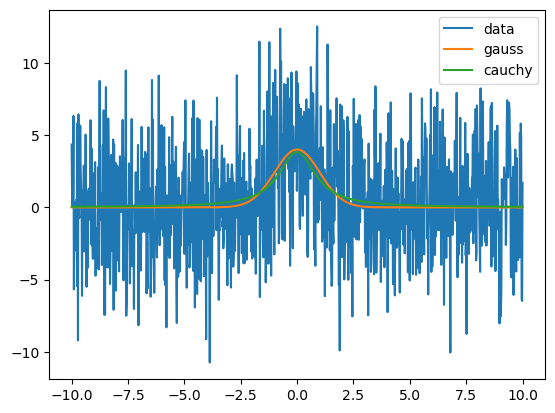

In [19]:
t_vals = np.linspace(-10.0, 10.0, 1000)
sigma = 3.5
amp_true = 4.0
mean_true = 0.0
true_data = gaussian_pulse(t_vals, amp_true, mean_true)
data = true_data + np.random.randn(*t_vals.shape) * sigma
cauchy_data = cauchy_pulse(t_vals, amp_true * 3, mean_true)
plt.plot(t_vals, data, label="data")
plt.plot(t_vals, true_data, label="gauss")
plt.plot(t_vals, cauchy_data, label="cauchy")
plt.legend()
# plt.plot(x_vals, np.exp(log_like_fn()))
# plt.plot(x_vals, np.exp(log_like_gauss(x_vals)))

我们将遵循与上一个问题相同的设置顺序。从基本的声明(`ntemps`、`ndims`等)开始。对于这个问题，两个模型的最大叶节点都应该是1，最小叶节点都应该是0。

In [20]:
ntemps = 10
nwalkers = 30

ndims        = {"gauss": 2, "cauchy": 2}           # The dimensions of the two models we sample for here (# of parameter for each pulse, and # of parameters for the noise)
nleaves_max  = {"gauss": 1, "cauchy": 1}   # Maximum number of components for each model type (noise is 1, because we don't want to use RJ MCMC on it).
nleaves_min = {"gauss": 0, "cauchy": 0}
branch_names = ["gauss", "cauchy"]


现在我们将把两个模型的先验信息放在一起。两个模型的先验是完全相同的。振幅先验应跨越注入值。平均先验应该跨越时间域。

In [21]:
priors = {}
priors["gauss"] = ProbDistContainer({
    0: uniform_dist(0.0, 40.0),
    1: uniform_dist(t_vals.min(), t_vals.max())
}) 

priors["cauchy"] = ProbDistContainer({
    0: uniform_dist(0.0, 40.0),
    1: uniform_dist(t_vals.min(), t_vals.max())
}) 

现在我们将生成与之前相同类型的`GaussianMove`。我们需要确保为每个模型提供协方差!因此，它必须是一个包含两个模型条目的字典。不过，这些条目实际上可以是相同的。

In [22]:
factor = 0.01
cov    = {"gauss": np.diag(np.ones(2)) * factor, "cauchy": np.diag(np.ones(2)) * factor}
moves = GaussianMove(cov)


实例化`EnsembleSampler`

In [23]:
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    log_like_wrap,
    priors,
    nbranches=2,
    branch_names=branch_names,  # order determines order of parameter sets in Likelihood
    tempering_kwargs=dict(ntemps=ntemps, Tmax=np.inf),
    args=(t_vals, data, sigma),
    rj_moves=True,
    moves=moves,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min
)


生成起点。**注意**:这非常重要。这个测试只在以下情况下有效:
* 我们有**2**个模型，
* 每个模型的叶子数的最大值为1，最小值为0，
* 并且起始点必须都具有高斯脉冲或柯西脉冲的**其中之一**，而不是两者都具有或都不具有。

在这种设置中，每个建议框将建议切换模型并从其先验模型中提取。

生成起始点并使用`inds`数组告诉采样器每个漫步者只有一个模型实例。

In [24]:
start_point = {name: priors[name].rvs(size=(ntemps, nwalkers, 1)) for name in branch_names}

# draw randomly which model to start in 
model_index = np.random.randint(0, 2, size=(ntemps, nwalkers, 1))

inds = {name: np.zeros((ntemps, nwalkers, 1), dtype=bool) for name in branch_names}

inds["gauss"][model_index == 0] = True
inds["cauchy"][model_index == 1] = True

assert np.all(inds["gauss"].astype(int) + inds["cauchy"].astype(int) == 1)
start_state = State(start_point, inds=inds)


运行老化取样器。

In [25]:
nteps = 500
sampler.run_mcmc(start_state, nsteps, progress=True, burn=100)

100%|██████████| 5000/5000 [02:36<00:00, 31.92it/s]



为了计算后验比值比，我们需要得到存在于两种状态之一的冷链样本所占的比例。计算优势比。

In [26]:
nleaves = sampler.get_nleaves()

In [28]:
# number of cold-chain Gaussians / number of cold-chain samples
nleaves["gauss"][:, 0].sum() / np.prod(nleaves["gauss"][:, 0].shape)

0.7195

### 问题:

如果我们改变噪声，这会对我们的结果有什么影响?当一个模型的分数为1时，会发生什么?这是对比值比的正确估计吗?在初始优势比为1的情况下，我们该如何估计优势比呢?

# 学习总结和收获概述


## 教程内容概述
教程5（第六个）介绍了在基础模型发生变化时如何运行Eryn工具使用RJMCMC方法。该模型和方法适用在模型参数空间的维度在模型比较时发生变化，可以帮助我们理解和解决模型选择的问题。
## 学习总结
在本教程中，我的学习如下
1. RJMCMC方法的应用：本人在教程中学习了实现和运行RJMCMC，用在具有不同维度参数空间的模型间进行跳跃（可以用来模型选择和假设测试）
2. 模型比较与选择：如何使用RJMCMC进行模型比较
3. Eryn工具：Eryn工具在复杂数据分析中的相关应用
4. 重温以及学习了一些关于概率论和数理统计的相关先验知识，帮助我理解教程中的一些数据处理的缘由和方法（当然了，还有这些概统知识如何写于Python上）